# EH_05_Data Wrangling Canadian Poker Player Earnings
Prepared by Eric Hui

## Purpose
Web scraping and wrangling Canadian poker player earnings from Hendon Mob Poker Database

## Methodology
Using Python and requests, we will web scrape detailed information of the top Canadian poker players. Then make visualizations and observe any interesting trends.

## Install/Import dependencies

In [216]:
# Data manipulation
import pandas as pd
import numpy as np
import itertools

# Web
import requests
from bs4 import BeautifulSoup as bsoup

# Time/Sleep
import time
import datetime
import random

# Visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
BASE_URL="https://pokerdb.thehendonmob.com" # starting base url
RANK_URL="/ranking/4119"
MAX_NUM_PAGES=30 # number of pages


# Data import
We retrieve all the required data for the analysis.

#### Helper Functions

In [4]:
def scrape_page(url):
    '''
    Scrape a page from base url
    '''
    r=requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    soup=bsoup(r.text)
    temp=soup.find_all('div', {'class':'block-common'})
    raw_table=temp[1].find('table', {'class':'table'})
    table=raw_table.find_all('tr')
    return get_ranking_table_data(table)

def get_ranking_table_data(table):
    '''
    Parse ranking table data and return it as a nested list (convert to dataframe afterwards)
    Returns: list 
    '''
    ranking_data=[]
    for row in table:
        rank=row.find('td',{'class':'place'}).text # ranking
        name=row.find('td',{'class':'name'}).text.strip() # player name
        # player detailed info url, replace with s for stats page
        player_url=str(row.find('a',href=True)['href']).replace('=r','=s') 
        ranking_data.append([rank,name,player_url])
    return ranking_data
   
def scrape(num_pages):
    '''
    Scrape a predetermined number of pages
    '''
    if num_pages>MAX_NUM_PAGES:
        print('Error: Too many pages')
        return None
    total_data=[]
    num_pages+=1
    sum=0
    for i in range(1,num_pages):
        total_data.append(scrape_page(BASE_URL+RANK_URL+"/"+str(i)))
        print(f'{len(total_data[i-1])} records retreived on page {i}')
        #if i<num_pages-1:
        #    wait=random.randint(6,12)
        #    print(f'Sleeping for {wait} seconds')
        #    time.sleep(wait)
    print(f'Operation complete. Total of {len(total_data)} pages scraped.')    
    total_data=list(itertools.chain(*total_data))
    print(f'Total of {len(total_data)} records scraped')
    return total_data

### Scrape data

In [5]:
# scrape 30 pages worth of players
raw_data=scrape(num_pages=30)

df_players_url=pd.DataFrame(raw_data)
df_players_url

100 records retreived on page 1
100 records retreived on page 2
100 records retreived on page 3
100 records retreived on page 4
100 records retreived on page 5
100 records retreived on page 6
100 records retreived on page 7
100 records retreived on page 8
100 records retreived on page 9
100 records retreived on page 10
100 records retreived on page 11
100 records retreived on page 12
100 records retreived on page 13
100 records retreived on page 14
100 records retreived on page 15
100 records retreived on page 16
100 records retreived on page 17
100 records retreived on page 18
100 records retreived on page 19
100 records retreived on page 20
100 records retreived on page 21
100 records retreived on page 22
100 records retreived on page 23
100 records retreived on page 24
100 records retreived on page 25
100 records retreived on page 26
100 records retreived on page 27
100 records retreived on page 28
100 records retreived on page 29
22 records retreived on page 30
Operation complete. 

,0,1,2
0,1st,Daniel Negreanu,/player.php?a=s&n=181
1,2nd,Timothy Adams,/player.php?a=s&n=88149
2,3rd,Sam Greenwood,/player.php?a=s&n=113537
3,4th,Daniel Dvoress,/player.php?a=s&n=264160
4,5th,Mike McDonald,/player.php?a=s&n=96339
...,...,...,...
2917,"2,918th",Ricardo Teves,/player.php?a=s&n=680943
2918,"2,919th",Jushia Jackson,/player.php?a=s&n=666704
2919,"2,920th",Graham Richards,/player.php?a=s&n=699883
2920,"2,921st",Stephen Goodger,/player.php?a=s&n=949949


### Get earnings stats from every player

#### Helper Functions

In [22]:
def scrape_player_tables(url):
    '''
    Scrape tables from a player page
    '''
    r=requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    tables=pd.read_html(r.text)
    
    return tables

def format_player_earnings(player_earnings,player_name):
    '''
    Pass in a dataframe containing a player's earnings in all regions and return only the world region
    '''
    df=player_earnings
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:]             #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # format and drop "Total" Earnings
    earnings_world=pd.concat([df.iloc[:,0],df.World],axis=1)
    earnings_world.columns=['Total',player_name]
    earnings_world=earnings_world.iloc[1:].reset_index(drop=True).T
    
    new_header = earnings_world.iloc[0] #grab the first row for the header
    earnings_world = earnings_world[1:] #take the data less the header row
    earnings_world.columns = new_header #set the header row as the df header
    
    return earnings_world

def get_all_player_earnings(players_table):
    '''
    Parse every player url in the players url table and return the earnings of the all players as a series
    '''
    start = time.time()
    all_player_earnings=[]
    #player_names_list=players_table[1] #reference 2nd column for names
    #url_list=players_table[2] #reference 3rd column in for urls
    
    players=zip(players_table[1],players_table[2])
    total=len(players_table)
    
    for i,d in enumerate(players,start=0): 
        # retrieve all tables 
        #print(d[1])
        player_data=scrape_player_tables(BASE_URL+d[1]);
                
        # table 2 contains earnings data
        player_earnings=player_data[2]
        all_player_earnings.append(format_player_earnings(player_earnings,d[0])); # format to only world earnings
        
        print(f'Players parsed: {i+1}/{total}',end='\r')
    
    print(f'\nOperation completed. Time elapsed: {str(datetime.timedelta(seconds = round(time.time()-start,2)))} seconds.')
    
    return all_player_earnings

### Scrape the earnings statistics

In [23]:
player_earnings=get_all_player_earnings(df_players_url)

Players parsed: 2922/2922
Operation completed. Time elapsed: 0:24:20.230000 seconds.


### Store to notebook

In [25]:
# store to this notebook
%store player_earnings

Stored 'player_earnings' (list)


In [27]:
# retrieve
%store -r player_earnings

## Data preprocessing

Now that the data has been scraped, clean it a bit

#### Helper Functions

In [29]:
def append_player_earnings(player_earnings):
    '''
    Return a nested list of all player's earnings.
    '''
    new_player_earnings=[]
    for i in (player_earnings):
        new_player_earnings.append(i.iloc[0])
    return new_player_earnings

In [109]:
all_player_earnings=append_player_earnings(player_earnings)
df_player_earnings=pd.DataFrame(all_player_earnings)
df_player_earnings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, Daniel Negreanu to Karen Paul
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2022    514 non-null    object
 1   2021    565 non-null    object
 2   2020    789 non-null    object
 3   2019    1396 non-null   object
 4   2018    1447 non-null   object
 5   2017    1347 non-null   object
 6   2016    1291 non-null   object
 7   2015    1191 non-null   object
 8   2014    1119 non-null   object
 9   2013    1041 non-null   object
 10  2012    870 non-null    object
 11  2011    727 non-null    object
 12  2010    634 non-null    object
 13  2009    476 non-null    object
 14  2008    347 non-null    object
 15  2007    247 non-null    object
 16  2006    158 non-null    object
 17  2005    116 non-null    object
 18  2004    67 non-null     object
 19  2003    33 non-null     object
 20  2002    29 non-null     object
 21  2001    24 non-null     object
 22  2000    2

## Data Preprocessing

Fill NA's and '-' with '0'

#### Helper Functions

In [339]:
# df_player_earnings=df_player_earnings.replace('-',0)
# df_player_earnings=df_player_earnings.replace(',','', regex=True)
# df_player_earnings=df_player_earnings.fillna(value=0)

def clean_player_earnings_table(df):
    for c in df.columns:
        df=df.fillna(value=0) # fill nan
        df[c]=df[c].map(str).str.replace('$','').str.strip()  # remove dollar sign
        df[c]=df[c].map(str).str.replace(',','').str.strip()  # remove comma
        df[c]=df[c].map(str).str.replace('-','0').str.strip()  # remove dash
    df=df.apply(pd.to_numeric) # change to numeric datatype
    return df

df=clean_player_earnings_table(df_player_earnings)
df

<ipython-input-339-c5204ca5bb92>:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



Total,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1995,1994,1993,1992,1991,1990,1989,1988,1987,1986
Daniel Negreanu,1046977,3122121,0,2223111,4510383,2700645,302452,2482489,10284118,3208630,...,0,0,0,0,0,0,0,0,0,0
Timothy Adams,2490345,1127500,5854376,8253042,2416870,3686371,1669636,218796,70205,1155362,...,0,0,0,0,0,0,0,0,0,0
Sam Greenwood,1864511,0,1403908,8373326,5747463,2457584,2029026,2040020,92094,212412,...,0,0,0,0,0,0,0,0,0,0
Daniel Dvoress,4899998,0,0,8928195,943809,3897847,1188942,737050,180553,28300,...,0,0,0,0,0,0,0,0,0,0
Mike McDonald,78250,0,0,46504,0,205176,544361,2427532,4423442,1112203,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ricardo Teves,0,0,0,134,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jushia Jackson,0,0,0,132,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Graham Richards,0,0,0,103,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Stephen Goodger,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualization 1.a

Transform dataframes for visualization

In [340]:
all_players=df.sum(axis=0)
top100=df[:100].sum(axis=0)
top25=df[:25].sum(axis=0)
top10=df[:10].sum(axis=0)
top3=df[:3].sum(axis=0)

df_plot=pd.DataFrame([all_players,top100,top25,top10,top3])
df_plot=df_plot[df_plot.columns[::-1]].T
df_plot.columns=['All Players','Top 100','Top 25' ,'Top 10','Top 3']

df_plot

,All Players,Top 100,Top 25,Top 10,Top 3
Total,,,,,
1986,75600,0,0,0,0
1987,0,0,0,0,0
1988,0,0,0,0,0
1989,0,0,0,0,0
1990,0,0,0,0,0
1991,434,0,0,0,0
1992,5289,0,0,0,0
1993,13296,0,0,0,0
1994,35295,0,0,0,0


In [229]:
df_all_players

Total
1986       75600
1987           0
1988           0
1989           0
1990           0
1991         434
1992        5289
1993       13296
1994       35295
1995      133406
1996       73126
1997      113592
1998      412342
1999      423713
2000       67759
2001      323350
2002      555394
2003      707027
2004     5138365
2005     5196240
2006    11401825
2007    14837551
2008    18363661
2009     9589204
2010    14402016
2011    15221002
2012    12903397
2013    21768702
2014    31541842
2015    17978364
2016    23420866
2017    30177551
2018    35058444
2019    55659884
2020    13037867
2021    11017879
2022    15477613
dtype: int64

In [341]:
fig = px.line(df_plot,
              title='Canadian Poker Players - Annual Earnings',
              #log_y=True # log scale
             )

fig = fig.update_layout(xaxis_title="Year", 
                        yaxis_title="Amount Earned")

# highlight 2008 recession
fig.add_vrect(x0=21, x1=23,
              annotation_text="Great Recession, 2007-2009", annotation_position="left",
              fillcolor="red", opacity=0.3, line_width=0)

# highlight covid start
fig.add_vrect(x0=33, x1=36,
              annotation_text="Covid-19, 2019-Present", annotation_position="top left",
              fillcolor="red", opacity=0.3, line_width=0)

fig.show()

In case of graphs not showing, it is shown again below in image format:

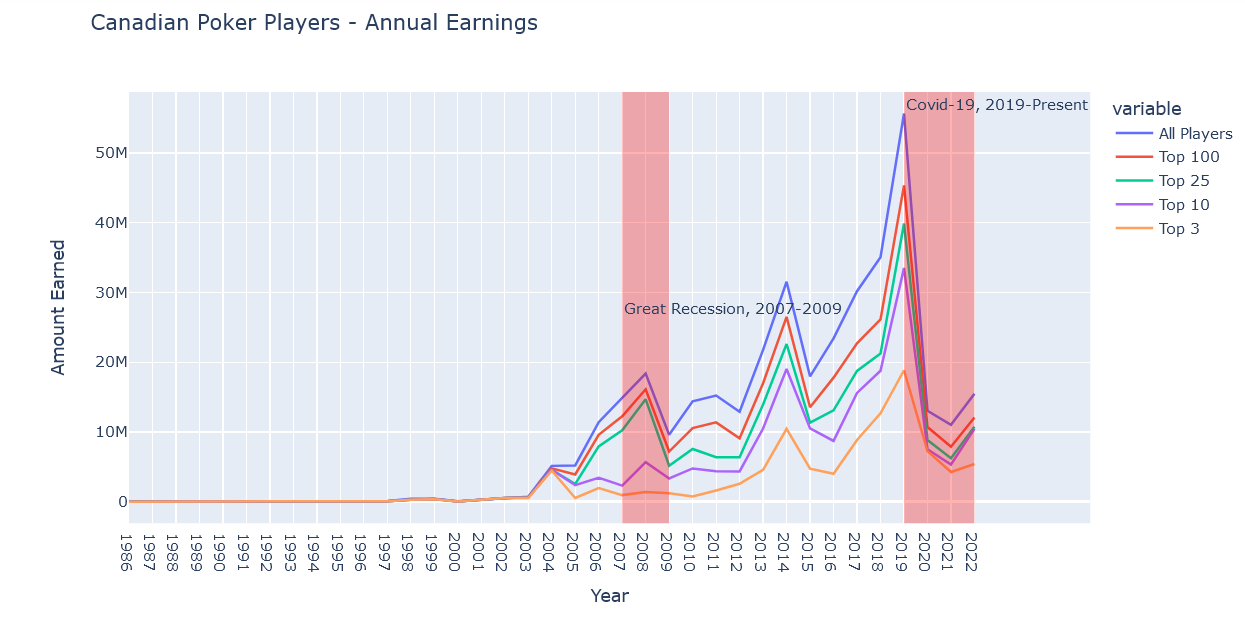

In [258]:
df_plot.T

Total,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1995,1994,1993,1992,1991,1990,1989,1988,1987,1986
All,15477613,11017879,13037867,55659884,35058444,30177551,23420866,17978364,31541842,21768702,...,133406,35295,13296,5289,434,0,0,0,0,75600
Top 300,13767800,9729760,11965875,50171530,30740420,26668296,21127445,15913463,29275820,19268842,...,133014,26881,808,3345,0,0,0,0,0,0
Top 100,12065962,7886097,10701565,45362645,26135077,22714606,17790083,13540747,26503499,16979339,...,0,0,0,0,0,0,0,0,0,0
Top 10,10439388,5332074,7506308,33509766,18774352,15595368,8715912,10513437,19018961,10484288,...,0,0,0,0,0,0,0,0,0,0
Top 3,10439388,5332074,7506308,33509766,18774352,15595368,8715912,10513437,19018961,10484288,...,0,0,0,0,0,0,0,0,0,0


## Observations and Insights - 1.b

- During the 2007-09 recession, the earnings of the top 3 and top 10 Canadian players were less impacted than the remaining players. It appears that stronger players were able to continue to generate earnings despite economic trouble.


- During 2014-2015, the earnings of all Canadian players had fallen fairly uniformly. More research is to be done as to the potential factors affecting this (Eurozone Crisis? Oil pricing crash? Regulation changes? Reduction of tournaments? etc). It is also possible that 2013 was an exceptional year and that the following year is reversion to the mean. 


- During the ongoing Covid-19 pandemic, the earnings of players also fell more uniformly. A hypothesis could be that the closure of venues and events lead to the reduction of opportunities for all poker players to have any chance of earnings.




## Visualization 2.a

Transform dataframes for visualization

In [437]:
'''top3_details=df[:3][df.columns[::-1]].unstack().reset_index()
top3_details.columns=['Year','Name','Amount']
top3_details['Year']=pd.to_numeric(top3_details['Year'])
top3_details'''

df_top3=df[:3][df.columns[::-1]].T
df_top3.tail()

,Daniel Negreanu,Timothy Adams,Sam Greenwood
Total,,,
2018,4510383,2416870,5747463
2019,2223111,8253042,8373326
2020,0,5854376,1403908
2021,3122121,1127500,0
2022,1046977,2490345,1864511


In [438]:
fig = px.line(df_top3,
              title='Top 3 Canadian Poker Players - Annual Earnings',
             )
fig = fig.update_layout(xaxis_title="Year", 
                        yaxis_title="Amount Earned")
fig.show()

In case graphs not showing, it is shown again below in image format:

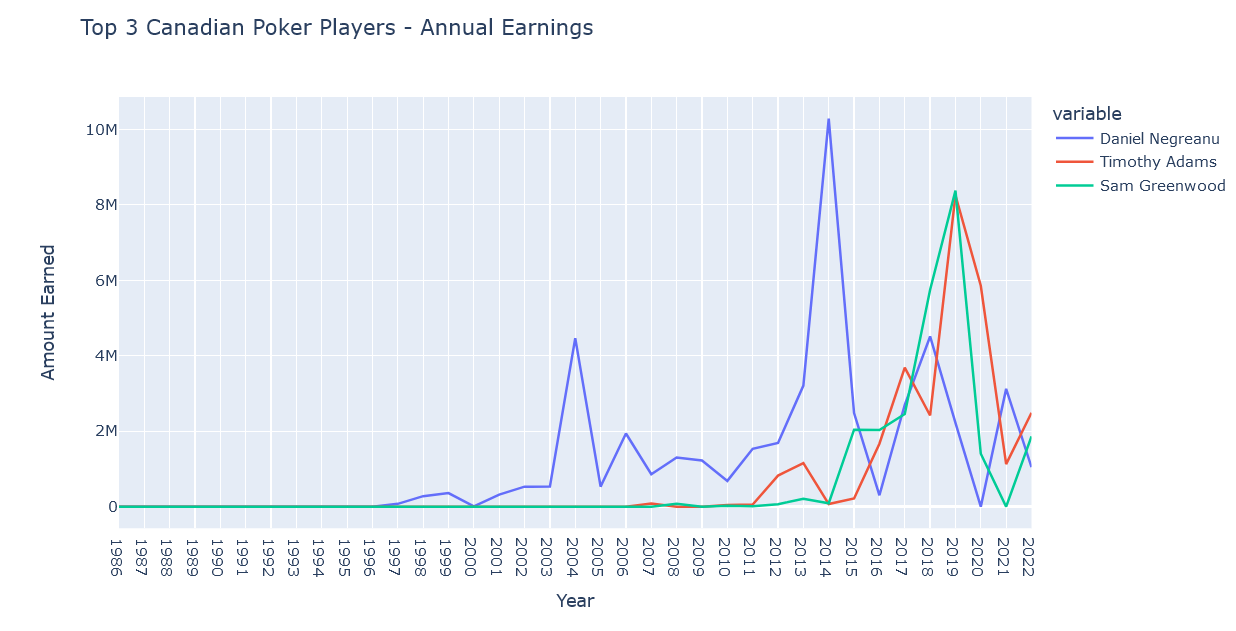

## Observations and Insights - 2.b

- We can see that Daniel Negreanu earned his greatest amount in 2014 at approx \\$10.4 million.
- Timothy Adams and Sam Greenwoord are rising stars who earned their highest amounts of approx \\$8.25 and \\$8.37 million in 2019.